---

# University of Liverpool

## COMP534 - Applied AI

---

This notebook is associated with Assignment 1. Use it to complete the assignment by following the instructions provided in each section, which includes a text cell describing the requirements. For additional details, see the Canvas.

In [1]:
# import libraries here
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


# 1. **Data Management**


In this part, you need to:

1.   analyse and prepare the data. Use plots, graphs, and tables (such as histogram, box plots, scatterplots etc.) to better analyse the dataset and identify issues or potential improvements in the data, including (but not limited to) unnecessary feature/variable which can be dropped/removed, standardization, encoding, etc;
2.   split the data and define your experimental protocol (such as cross-validation or k-fold).

In [2]:
# First reaad in data set and assign valid parameter ranges based on the dataset description
df = pd.read_csv('data/assign1-grades.csv')

valid_school = ['GP', 'MS']
valid_sex = ['F', 'M']
valid_address = ['U', 'R']
valid_famsize = ['GT3', 'LE3']
valid_pstatus = ['T', 'A']
valid_reason = ['home', 'reputation', 'course', 'other']
valid_yes_no = ['yes', 'no']
valid_4scale = np.arange(5)
valid_5scale = np.arange(6)
valid_grade = np.arange(21)

minpass_grade = 12

# Ensure str columns are in the proper case 

upper_columns = ['school', 'sex', 'address', 'famsize', 'Pstatus']
lower_columns = ['reason', 'guardian', 'schoolsup', 'famsup', 'paid',
                 'activities', 'nursery', 'higher', 'internet', 'romantic']

for col in upper_columns:
    df[col] = df[col].str.upper()

for col in lower_columns:
    df[col] = df[col].str.lower()

# Remove null and invalid data 

df = df[df['school'].isin(valid_school)]
df = df[df['sex'].isin(valid_sex)]
df = df[df['address'].isin(valid_address)]
df = df[df['famsize'].isin(valid_famsize)]
df = df[df['Pstatus'].isin(valid_pstatus)]
df = df[df['reason'].isin(valid_reason)]
df = df[df['Grade'].isin(valid_grade)]

scale4 = ['Medu', 'Fedu', 'traveltime', 'studytime']
scale5 = ['famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health']
yes_no = ['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
          'internet', 'romantic']

for col in scale4:
    df = df[df[col].isin(valid_4scale)]

for col in scale5:
    df = df[df[col].isin(valid_5scale)]

#print(df[yes_no])
#for col in yes_no:
#    df = df[df[col].isin(valid_yes_no)]

# Create the target column of pass/fail based on min Grade

df['result'] = np.where(df['Grade'] >= minpass_grade, 'pass', 'fail')


Now that the initial validation is complete we can analyse the data set and look for outliers and irrelevant columns

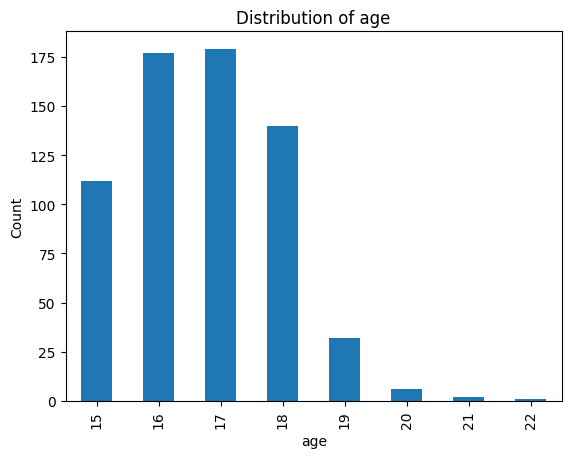

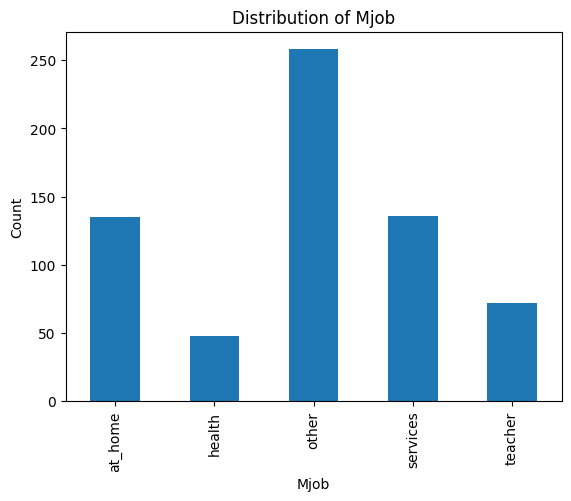

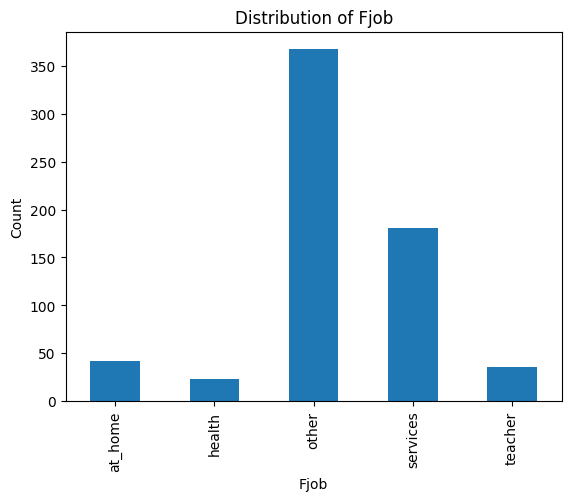

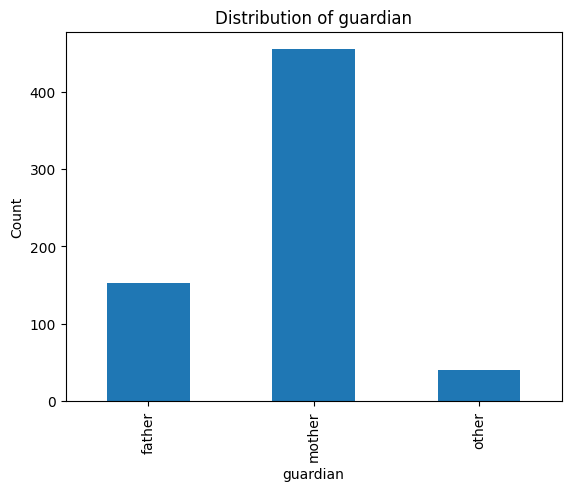

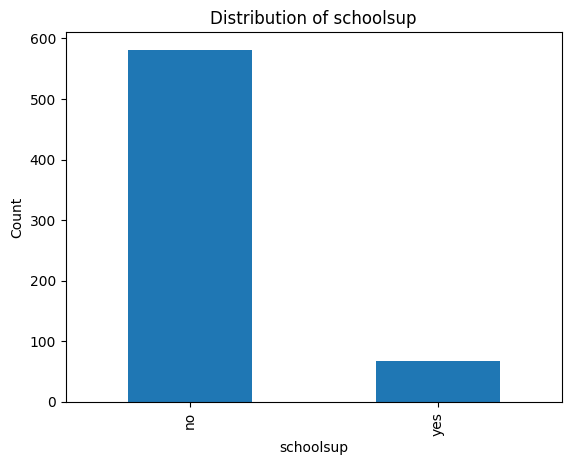

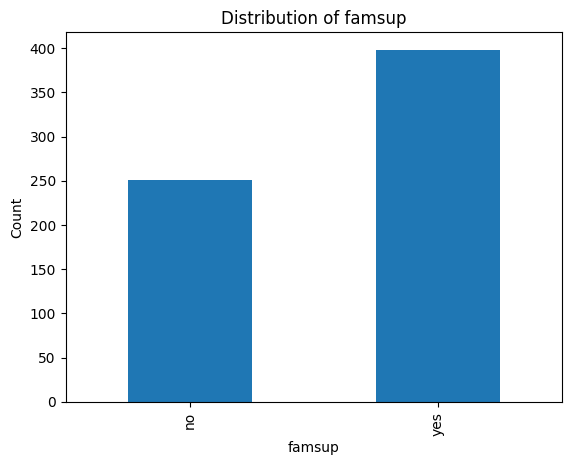

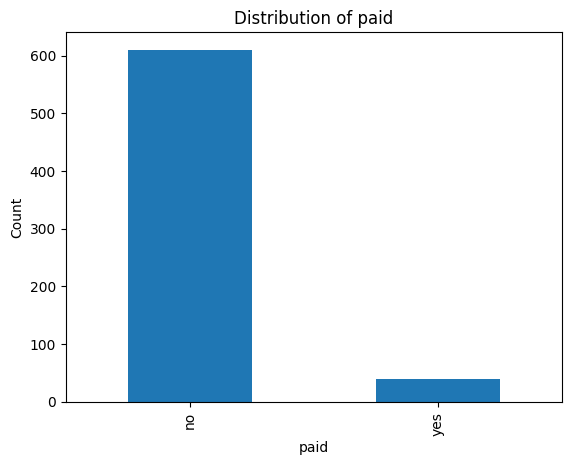

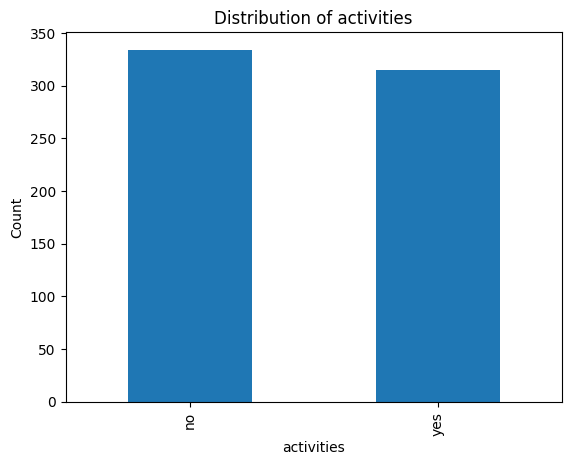

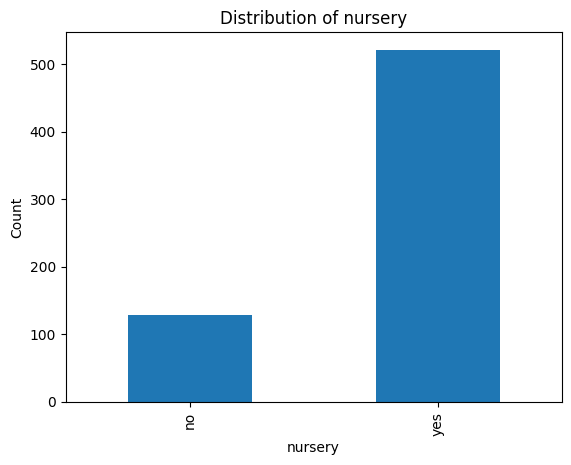

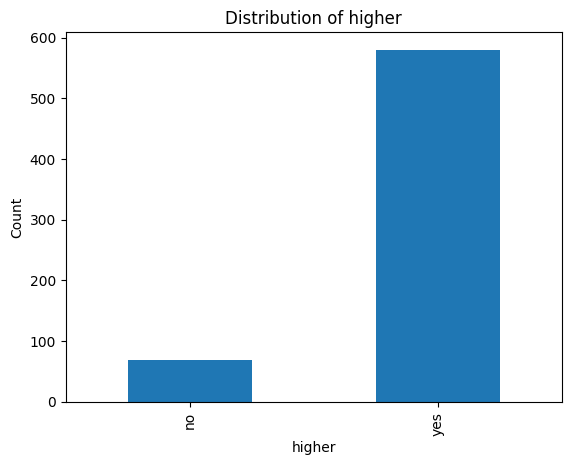

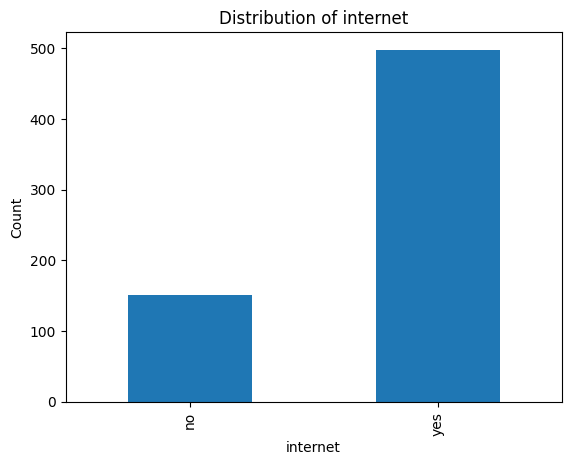

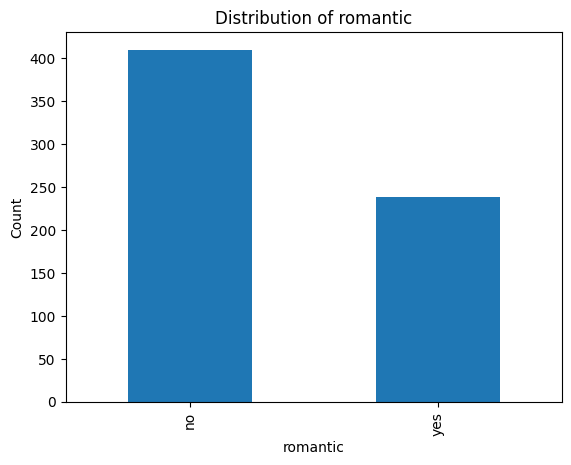

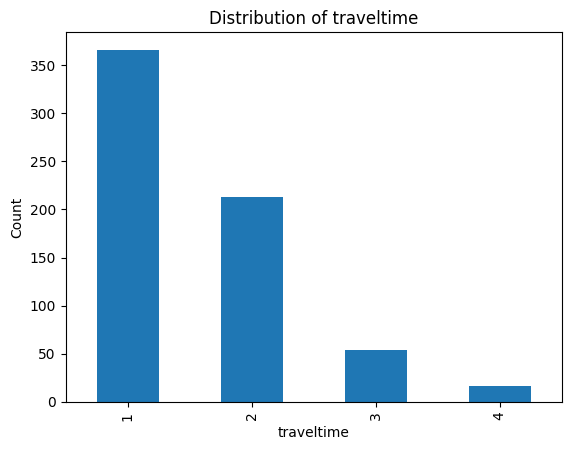

In [3]:
all_column = ['age', 'Mjob', 'Fjob', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'traveltime']
#all_column = df.columns.values()

# Give specific rows counts
for i in all_column:
    value_counts = df[i].value_counts().sort_index()
    #print(value_counts)

# Draw bar chart for each column
for column in all_column:
    data_counts = df[column].value_counts().sort_index()
    plt.figure()
    data_counts.plot(kind='bar')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.title(f'Distribution of {column}')
    plt.show()

In [4]:
# Remove outliers and unnecessary columns

df = df[df['age'] < 22]
df = df.drop(columns=['paid', 'Grade'])

In [ ]:
df = df.drop(columns=["Unnamed: 0"], errors="ignore") # dropping the index column

# Encode data to allow for further analysis

boolean_columns = ["schoolsup", "famsup", "activities", "nursery", "higher", "internet", "romantic"]
df[boolean_columns] = df[boolean_columns].apply(lambda x: x.map({"yes": 1, "no":0})) #converting boolean data to numerical data representations

binary_columns = ["school", "sex", "address", "famsize", "Pstatus", "result"]
df_encoded = pd.get_dummies(df, columns = binary_columns, drop_first= True ) #one-hot encoded (dummy) variables to handle categorical data

categorical_columns = ["Mjob", "Fjob", "reason", "guardian"]
df_encoded = pd.get_dummies(df_encoded, columns = categorical_columns, drop_first = False)

df_encoded = df_encoded[df_encoded.columns.drop(list(df_encoded.filter(regex='_other')))]

# Normalise absences
scaler = MinMaxScaler()
df_encoded['absences'] = scaler.fit_transform(df_encoded[['absences']])

df_encoded = df_encoded.drop(columns=["Unnamed: 0"], errors="ignore") # dropping the index column

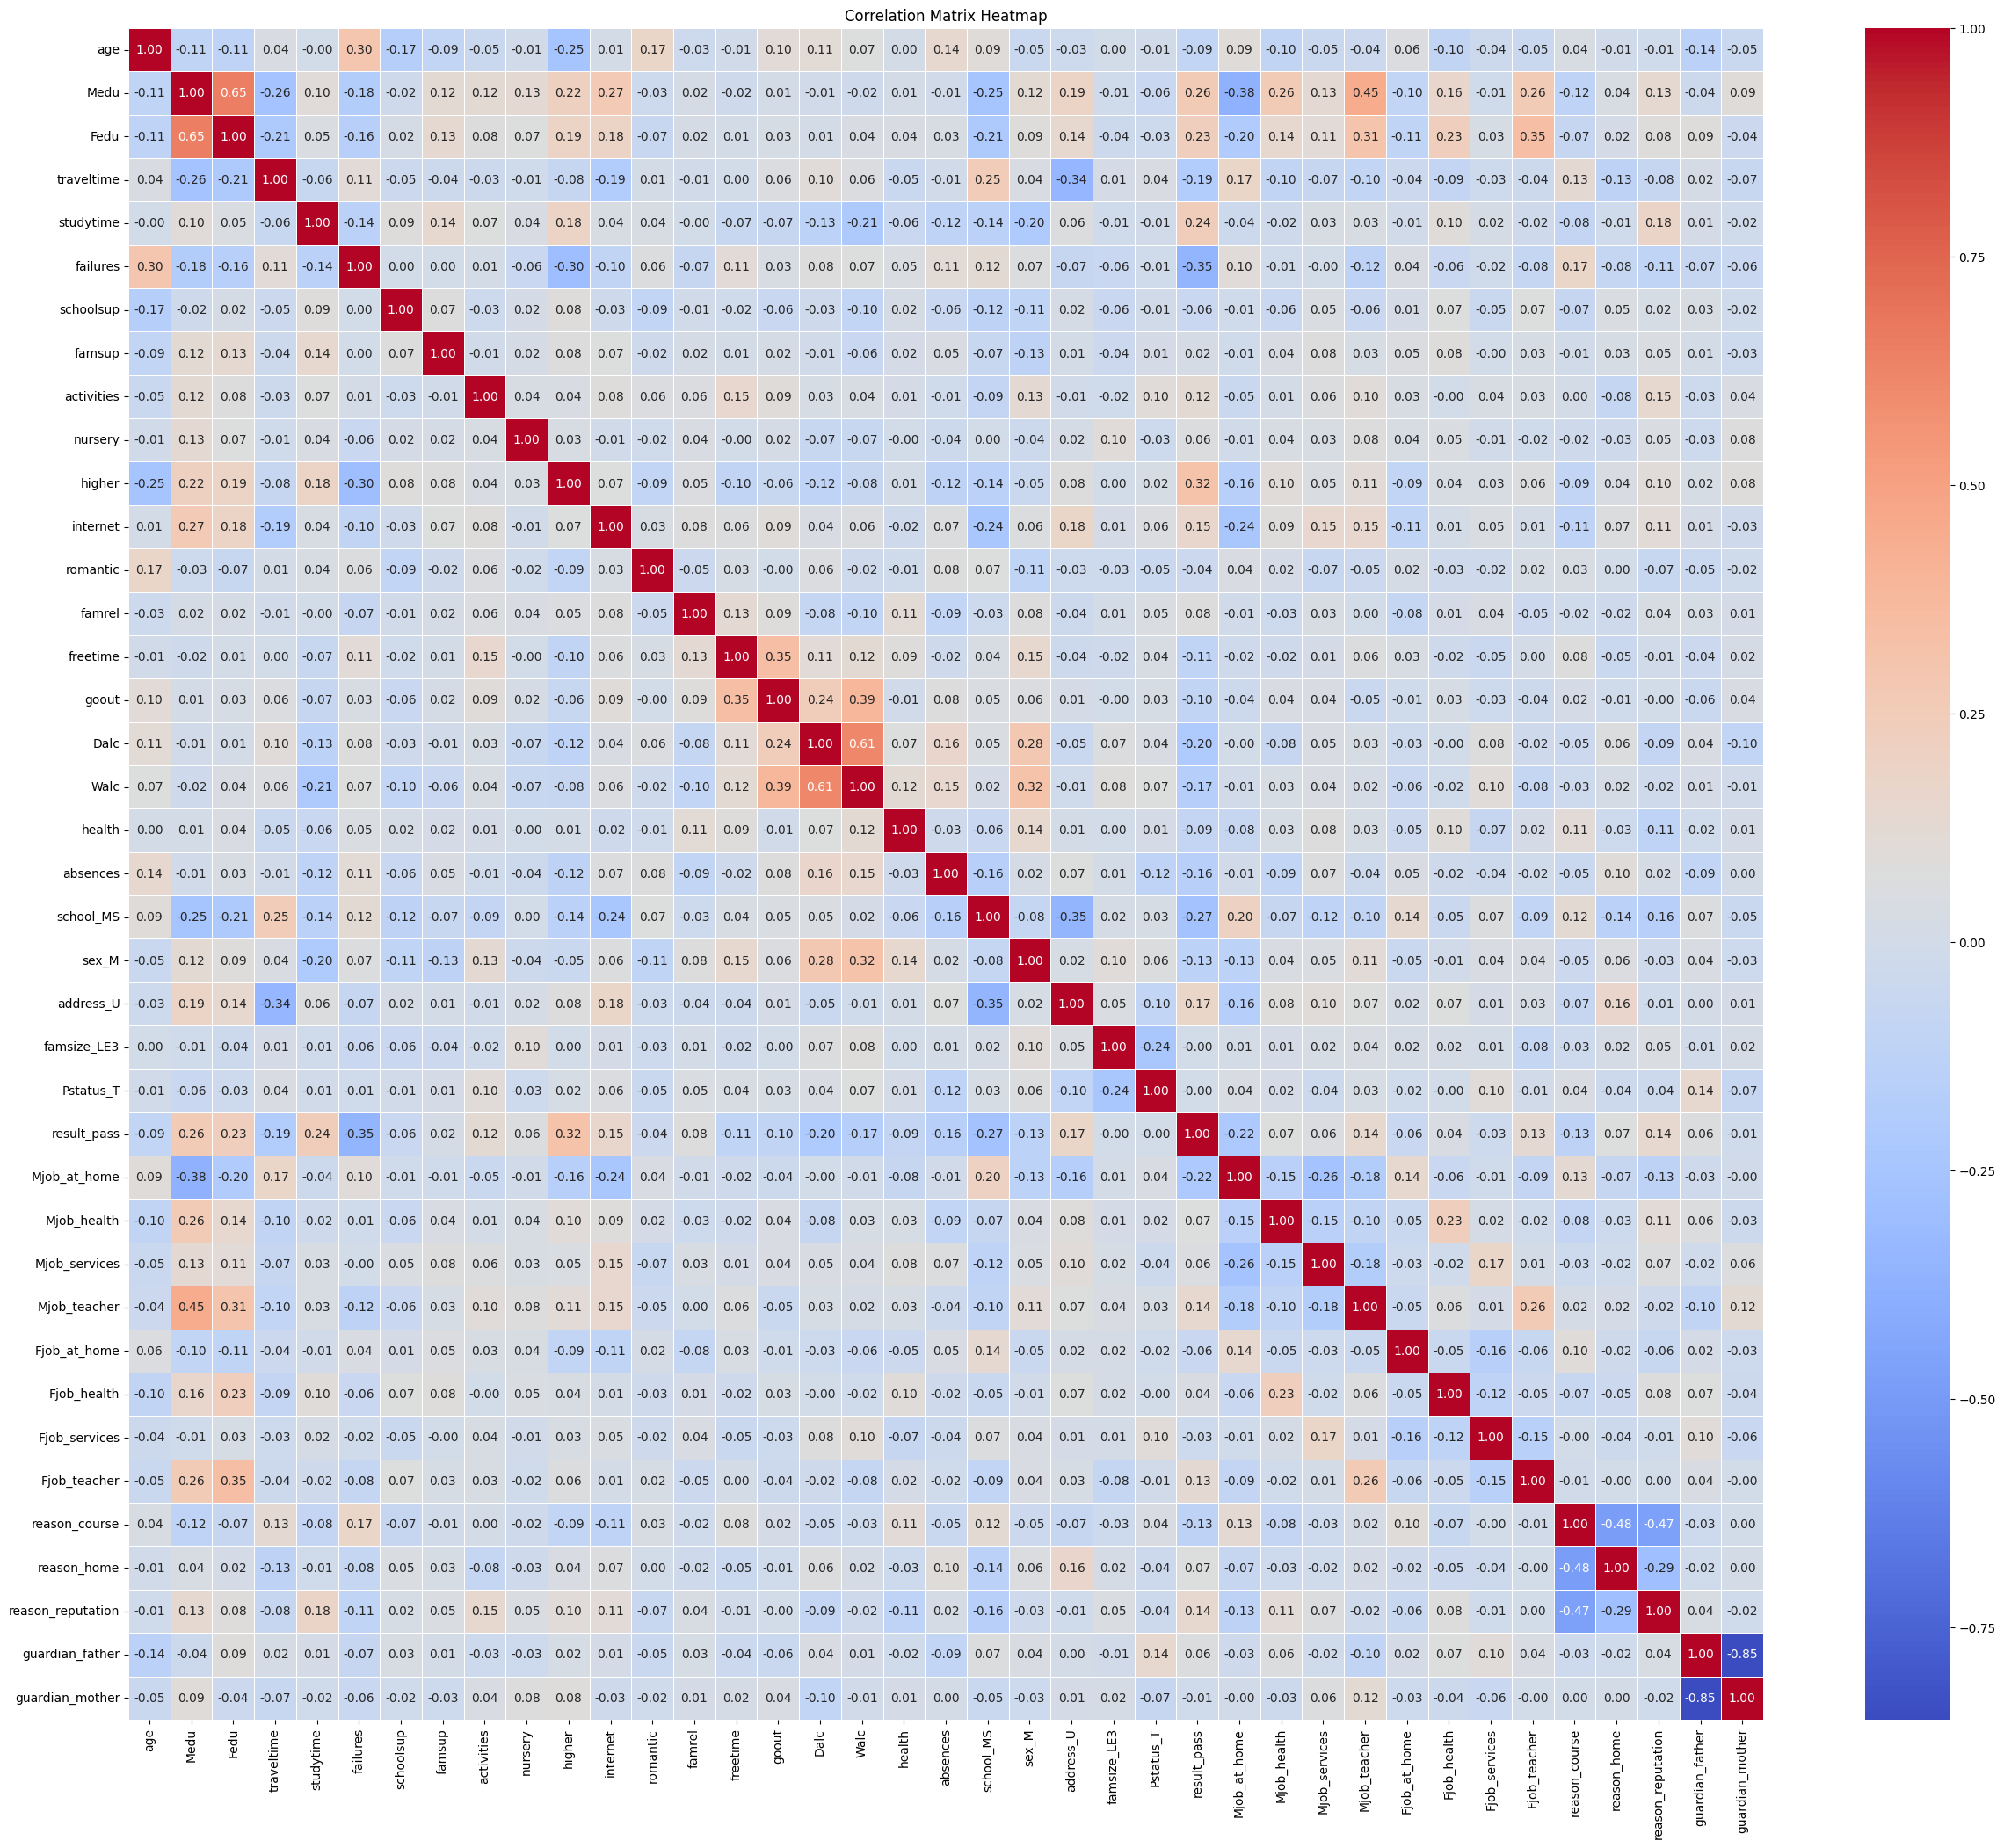

In [ ]:
# Compute correlation
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(30,25))
sns.heatmap (correlation_matrix, cmap= "coolwarm", annot = True, fmt= ".2f", linewidths= 0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

In [7]:
X = df_encoded.drop(columns=['result_pass']).astype(int)
X = sm.add_constant(X)  

y = df_encoded['result_pass']

# Logistic Regression
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())

         Current function value: 0.472603
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:            result_pass   No. Observations:                  648
Model:                          Logit   Df Residuals:                      609
Method:                           MLE   Df Model:                           38
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                  0.3155
Time:                        13:53:33   Log-Likelihood:                -306.25
converged:                      False   LL-Null:                       -447.38
Covariance Type:            nonrobust   LLR p-value:                 4.492e-39
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -3.1553      2.063     -1.530      0.126      -7.198       0.887
age                   0.1322      0.099     

c:\Users\maddy\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [8]:
# Drop columns based very low correlation and low significance 

df_encoded = df_encoded.drop(columns=['famsup', 'guardian_mother', 'guardian_father', 'Pstatus_T', 'famsize_LE3'])

In [9]:
vif_data = pd.DataFrame()
X = X.drop(columns=['const'])

vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

              Feature        VIF
0                 age  75.301081
1                Medu  15.700258
2                Fedu  11.277834
3          traveltime   6.689947
4           studytime   7.754442
5            failures   1.476516
6           schoolsup   1.229156
7              famsup   2.860417
8          activities   2.208402
9             nursery   5.422529
10             higher  11.423087
11           internet   5.327602
12           romantic   1.759957
13             famrel  19.794910
14           freetime  12.375469
15              goout  12.093901
16               Dalc   6.592624
17               Walc   8.712638
18             health   7.971484
19           absences   1.038179
20          school_MS   2.204993
21              sex_M   2.316243
22          address_U   4.283305
23        famsize_LE3   1.626339
24          Pstatus_T   9.510670
25       Mjob_at_home   1.740865
26        Mjob_health   1.537348
27      Mjob_services   1.829499
28       Mjob_teacher   1.953358
29       F

In [10]:
# Remove and combine columns - I'm lost help

#df_encoded['Pedu'] = (df_encoded['Medu'] + df_encoded['Fedu']) / 2
#df_encoded['alc'] = (df_encoded['Walc'] + df_encoded['Dalc']) / 2
df_encoded = df_encoded.drop(columns=['age', 'famrel', 'goout', 'freetime', 'Fedu', 'Walc'])

In [11]:
vif_data2 = pd.DataFrame()
X = df_encoded.drop(columns=['result_pass']).astype(int)
vif_data2["Feature"] = X.columns
vif_data2["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data2)


              Feature        VIF
0                Medu  10.298037
1          traveltime   5.827323
2           studytime   7.018314
3            failures   1.313502
4           schoolsup   1.212711
5          activities   2.124420
6             nursery   5.056277
7              higher  10.155810
8            internet   4.834724
9            romantic   1.687852
10               Dalc   4.112708
11             health   6.702249
12           absences   1.023447
13          school_MS   1.964953
14              sex_M   2.117408
15          address_U   3.908241
16       Mjob_at_home   1.623840
17        Mjob_health   1.493562
18      Mjob_services   1.779797
19       Mjob_teacher   1.831904
20       Fjob_at_home   1.197551
21        Fjob_health   1.201962
22      Fjob_services   1.628316
23       Fjob_teacher   1.255024
24      reason_course   4.667894
25        reason_home   2.970246
26  reason_reputation   3.017277


In [12]:
# Split the data using the 5-fold method 
kfold = KFold(10, shuffle=True, random_state=42)

y = df_encoded['result_pass']
X = df_encoded.drop(columns=['result_pass'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


---

# 2. **Model Training**

Here, you need to:

1.	select and compare at least three machine learning models (seen/discussed during the lectures) appropriate for your modelling;
2.	if there are hyperparameters in a selected algorithm, define a hyperparameter search protocol (you can define your own), and tune them.


In [13]:
# Implementation of SVM model

# Define our classifier
classifier = svm.SVC()
#X = X.drop(columns=['traveltime'])

# Define hyperparameter grid
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']},
    {'kernel': ['poly'], 'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
     'degree': [2, 3, 4]}]

# Set up grid search to find the best hyperparams
grid_search = GridSearchCV(classifier, param_grid, cv=kfold,
                           scoring='accuracy', return_train_score=True)

print('Starting grid search to optimise hyperparams')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f'best hyperparameters: {best_params}')

best_svm = grid_search.best_estimator_

# Calculate accuracy scores
scores = cross_val_score(best_svm, X_train, y_train, cv=kfold, scoring='accuracy')

average_acc = np.mean(scores)

print(f"Accuracy Score for each fold: {[round(score, 4) for score in scores]}")
print(f"Average accuracy across 5 folds: {average_acc:.2f}")


# Print out scores for each param combo
accuracys = pd.DataFrame(grid_search.cv_results_)
#print(accuracys.columns)
accuracys = accuracys.sort_values('rank_test_score')
print(accuracys[['param_C', 'param_kernel', 'param_gamma', 'param_degree',
                'mean_train_score', 'mean_test_score']])


Starting grid search to optimise hyperparams
best hyperparameters: {'C': 1, 'kernel': 'linear'}
Accuracy Score for each fold: [0.7115, 0.7308, 0.6154, 0.8077, 0.75, 0.8269, 0.6923, 0.7692, 0.7843, 0.8039]
Average accuracy across 5 folds: 0.75
    param_C param_kernel param_gamma  param_degree  mean_train_score  \
1       1.0       linear         NaN           NaN          0.779065   
22     10.0         poly        auto           2.0          0.834407   
21     10.0         poly       scale           2.0          0.833120   
6       1.0          rbf        auto           NaN          0.785074   
18      1.0         poly        auto           3.0          0.804379   
5       1.0          rbf       scale           NaN          0.782929   
16      1.0         poly        auto           2.0          0.779280   
2      10.0       linear         NaN           NaN          0.781209   
0       0.1       linear         NaN           NaN          0.763409   
15      1.0         poly       scale 

In [ ]:
# Implementation of RandomForest Model

# Define the parameter grid for tuning
param_grid = {
    "n_estimators": [100, 200, 300],          # Number of trees
    "max_depth": [10, 20, None],              # Tree depth limit
    "min_samples_split": [2, 5, 10],          # Minimum samples to split a node
    "min_samples_leaf": [1, 2, 4],            # Minimum samples per leaf
    "max_features": ["sqrt", "log2"]          # Features considered per split
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(rf_model, param_grid, cv=kfold, scoring="accuracy", return_train_score=True)
grid_search.fit(X, y)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

# Print out scores for each param combo
accuracys = pd.DataFrame(grid_search.cv_results_)
#print(accuracys.columns)
accuracys = accuracys.sort_values('rank_test_score')
print(accuracys[['param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',
                'mean_train_score', 'mean_test_score']])

In [ ]:
# Implementation of Logistic Regression Model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

final_model = LogisticRegression(
    penalty=best_params['penalty'], 
    C=best_params['C'], 
    solver=best_params['solver'], 
    max_iter=best_params['max_iter']
)

final_model.fit(X_train_smote, y_train_smote)

y_pred_final = final_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"Final Logistic Regression Model Test Accuracy: {final_accuracy:.4f}")

---

# 3. **Evaluate models**

Here, you need to:

1.	test the model (the best one you obtained from the above stage) on the testing dataset.


In [66]:
# Write your proposed solution code here. Create more code cells if you find it necessary

best_model = best_svm

y_pred = best_model.predict(X_test)
print(accuracy_score(y_test, y_pred))


0.7307692307692307
